In [5]:
# DRX Initiate Bucket Analysis
# 본 분석은 DRX경기 데이터를 기반으로
# 조합 내 Initiate 능력을 수치화하고
# 해당 지표가 승률 및 상승기/하락기에
# 어떠한 영향을 미치는지 분석하는 것을 목표로 한다.
# 상승기/하락기 기준일은 2022-11-06(월즈 챔피언십 우승일)이다.

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

RAW_PATH = "data\reference\drx_2022_2025_0829_split.csv"
CHAMP_PATH = "data\reference\Champion_Final.csv"
CHAMP_INIT_PATH = "data\reference\Champion_initiate.csv"

RAW_PATH_df = pd.read_csv(RAW_PATH)
CHAMP_PATH_df = pd.read_csv(CHAMP_PATH)
CHAMP_INIT_PATH_df = pd.read_csv(CHAMP_INIT_PATH)

RAW_PATH_df.head()

,date,tournament,patch,w_l,side,vs,bans,bans_vs,picks,picks_vs,...,pick_vs_top,pick_vs_jg,pick_vs_mid,pick_vs_bot,pick_vs_sup,player_top,player_jg,player_mid,player_bot,player_sup
0,NaN,KR LCK 2022 Spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-12,KR LCK 2022 Spring,12.1,Loss,Blue,Liiv SANDBOX,"Diana,Caitlyn,Twisted Fate,LeBlanc,Viktor","Renekton,Lee Sin,Leona,Jayce,Akali","Graves,Viego,Ryze,Aphelios,Sona","Tryndamere,Xin Zhao,Syndra,Jhin,Yuumi",...,Tryndamere,Xin Zhao,Syndra,Jhin,Yuumi,Kingen,Pyosik,Zeka,Deft,BeryL
2,2022-01-12,KR LCK 2022 Spring,12.1,Loss,Blue,Liiv SANDBOX,"Diana,Caitlyn,Yuumi,Samira,Syndra","Renekton,Lee Sin,Twisted Fate,Viktor,LeBlanc","Graves,Jarvan IV,Ryze,Aphelios,Thresh","Tryndamere,Xin Zhao,Akali,Ezreal,Leona",...,Tryndamere,Xin Zhao,Akali,Ezreal,Leona,Kingen,Pyosik,Zeka,Deft,BeryL
3,2022-01-14,KR LCK 2022 Spring,12.1,Loss,Red,Gen.G,"Tryndamere,Renekton,Yuumi,Jayce,Lissandra","Caitlyn,Twisted Fate,Karma,Akshan,Rakan","Gwen,Xin Zhao,LeBlanc,Aphelios,Nautilus","Graves,Lee Sin,Corki,Ziggs,Leona",...,Graves,Lee Sin,Corki,Ziggs,Leona,Kingen,Pyosik,Zeka,Deft,BeryL
4,2022-01-14,KR LCK 2022 Spring,12.1,Loss,Blue,Gen.G,"Karma,Graves,Twisted Fate,Jarvan IV,Kennen","Yuumi,Renekton,Lee Sin,Akshan,Akali","Gragas,Xin Zhao,Viktor,Caitlyn,Lux","Tryndamere,Viego,Corki,Varus,Thresh",...,Tryndamere,Viego,Corki,Varus,Thresh,Kingen,Pyosik,Zeka,Deft,BeryL


In [6]:
RAW_PATH_df["win"] = RAW_PATH_df["w_l"].map({"Win": 1, "Loss":0})
RAW_PATH_df["win"].value_counts(dropna=False)

# 상승기/하락기 구간 컬럼
RAW_PATH_df["date"] = pd.to_datetime(RAW_PATH_df["date"])
PEAK_DATE = pd.Timestamp("2022-11-06")

RAW_PATH_df["period"] = np.where(
    RAW_PATH_df["date"] <= PEAK_DATE,
    "Peak (<=2022-11-06)",
    "Post-Peak (>=2022-11-07)"
)

RAW_PATH_df["period"].value_counts()


period
Post-Peak (>=2022-11-07)    292
Peak (<=2022-11-06)         131
Name: count, dtype: int64

In [7]:
def make_key(s):
    if pd.isna(s):
        return None
    s = str(s).lower()
    s = re.sub(r"[^a-z0-9]", "", s)
    return s

PICK_COLS = [
    "pick_top", "pick_jg", "pick_mid", "pick_bot", "pick_sup",
    "pick_vs_top", "pick_vs_jg", "pick_vs_mid", "pick_vs_bot", "pick_vs_sup"
]

for c in PICK_COLS:
    RAW_PATH_df[c + "_key"] = RAW_PATH_df[c].apply(make_key)

RAW_PATH_df[[c for c in PICK_COLS[:5]] + [c + "_key" for c in PICK_COLS[:5]]].head(3)

,pick_top,pick_jg,pick_mid,pick_bot,pick_sup,pick_top_key,pick_jg_key,pick_mid_key,pick_bot_key,pick_sup_key
0,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None
1,Graves,Viego,Ryze,Aphelios,Sona,graves,viego,ryze,aphelios,sona
2,Graves,Jarvan IV,Ryze,Aphelios,Thresh,graves,jarvaniv,ryze,aphelios,thresh


In [8]:
CHAMP_INIT_PATH_df["Champion_key"] = CHAMP_INIT_PATH_df["Champion"].apply(
    lambda x: re.sub(r"[^a-z0-9]", "", str(x).lower())
)
CHAMP_INIT_PATH_df["initiate_level"] = CHAMP_INIT_PATH_df["Initiate"].astype(int)
CHAMP_INIT_PATH_df.head()

,Champion,Initiate,Champion_key,initiate_level
0,Aatrox,0,aatrox,0
1,Ahri,1,ahri,1
2,Akali,1,akali,1
3,Akshan,0,akshan,0
4,Alistar,2,alistar,2


In [9]:
# 매핑
init_map = dict(
    zip(CHAMP_INIT_PATH_df["Champion_key"], CHAMP_INIT_PATH_df["initiate_level"])
)

def map_init(champ_key):
    return init_map.get(champ_key, 0)

for pos in ["top", "jg", "mid", "bot", "sup"]:
    RAW_PATH_df[f"init_{pos}"] = RAW_PATH_df[f"pick_{pos}_key"].apply(map_init)

for pos in ["top", "jg", "mid", "bot", "sup"]:
    RAW_PATH_df[f"init_vs_{pos}"] = RAW_PATH_df[f"pick_vs_{pos}_key"].apply(map_init)

In [25]:
# period별 전체 승률
baseline_period = (
    RAW_PATH_df.groupby("period")
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
)

baseline_period

baseline_period["winrate_pct"] = (baseline_period["winrate"] * 100).round(1)
baseline_period


,period,games,winrate,winrate_pct
0,Peak (<=2022-11-06),131,0.549618,55.0
1,Post-Peak (>=2022-11-07),276,0.322464,32.2


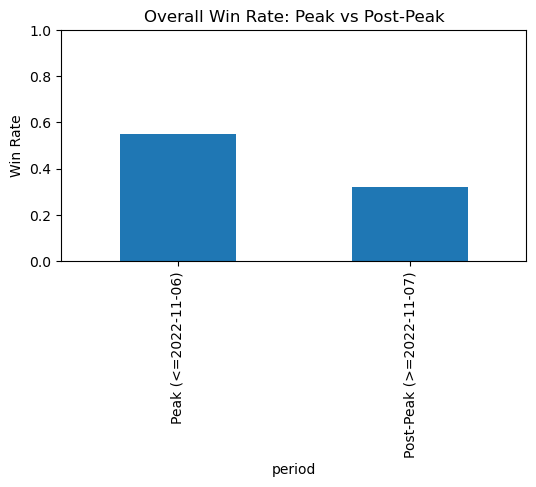

In [26]:
#시각화
baseline_period.set_index("period")["winrate"].plot(kind="bar", figsize=(6,3))
plt.ylim(0, 1)
plt.title("Overall Win Rate: Peak vs Post-Peak")
plt.ylabel("Win Rate")
plt.show()

In [29]:
# 상승기 구간 승률 약 55.0%, 하락기 구간 승률 약 32.2%로,
# 상승기와 하락기 간 승률은 뚜렷한 차이가 나타났다.
# 이러한 차이는 이후 분석할 initiate 구조 및 상대적 우위 분석에 대한
# 베이스 라인이 된다.

In [13]:
# Initiate_score 계산
our_cols = [f"init_{p}" for p in ["top", "jg", "mid", "bot", "sup"]]
vs_cols  = [f"init_vs_{p}" for p in ["top", "jg", "mid", "bot", "sup"]]

RAW_PATH_df["initiate_score"] = RAW_PATH_df[our_cols].sum(axis=1)
RAW_PATH_df["initiate_score_vs"] = RAW_PATH_df[vs_cols].sum(axis=1)
RAW_PATH_df["initiate_diff"] = RAW_PATH_df["initiate_score"] - RAW_PATH_df["initiate_score_vs"]

baseline_period

# Initiate_score 구간화
def bucket(x):
    if x <= 1:
        return "0-1"
    elif x <= 3:
        return "2-3"
    elif x <= 5:
        return "4-5"
    else:
        return "6+"

RAW_PATH_df["init_bucket"] = RAW_PATH_df["initiate_score"].apply(bucket)

# 버킷 정렬
order = ["0-1", "2-3", "4-5", "6+"]

# 상승기/하락기 비교
summary_period = (
    RAW_PATH_df.groupby(["period", "init_bucket"])
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
)
summary_period["init_bucket"] = pd.Categorical(summary_period["init_bucket"], categories=order, ordered=True)
summary_period = summary_period.sort_values(["period", "init_bucket"])

summary_period

,period,init_bucket,games,winrate
0,Peak (<=2022-11-06),0-1,10,0.500000
1,Peak (<=2022-11-06),2-3,46,0.521739
2,Peak (<=2022-11-06),4-5,59,0.610169
3,Peak (<=2022-11-06),6+,16,0.437500
4,Post-Peak (>=2022-11-07),0-1,5,0.400000
5,Post-Peak (>=2022-11-07),2-3,66,0.227273
6,Post-Peak (>=2022-11-07),4-5,141,0.326241
7,Post-Peak (>=2022-11-07),6+,64,0.406250


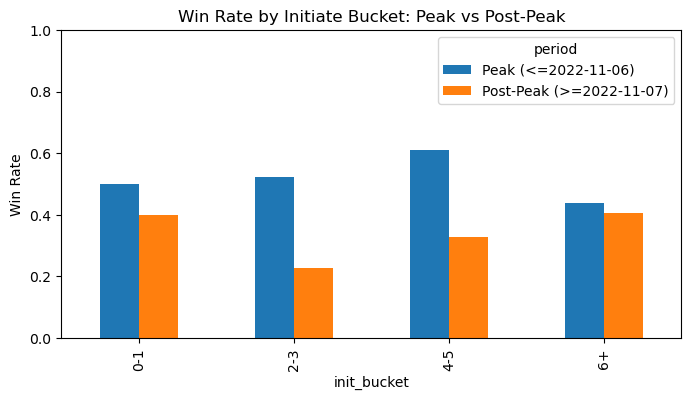

In [14]:
# 시각화

# DRX의 상승기/하락기 별
# Initiate 구조에 따른 승률 분포를 비교한다.
pivot = summary_period.pivot(index="init_bucket", columns="period", values="winrate")
pivot.plot(kind="bar", figsize=(8,4))
plt.ylim(0, 1)
plt.title("Win Rate by Initiate Bucket: Peak vs Post-Peak")
plt.ylabel("Win Rate")
plt.show()



In [ ]:
# 상승기 구간에서는
# 값이 커질수록 승률이 높아지지만
# 과한 Initiate조합은 오히려 승률이 낮아지는 것으로 보인다.
# 그러나 6+ 구간의 경기 표본이 적어 신뢰도는 낮아 보인다.

# 하락기 구간에서는 전체적으로 승률이 낮지만
# 0-1 구간, 6+구간이 승률이 높아 보인다.
# 그러나 0-1 구간의 경기 표본이 적어 신뢰도는 낮아 보인다.

In [22]:
# Initiate_diff Analysis
# Initiate 조합은 절대적 수치보다 상대적 수치가 중요할 수 있다.
# 이를 확인하기 위해 DRX와 상대 팀 간 Initiate 수치 차이에 따른
# 승률 변화를 분석한다.

# Initiate_diff 구간화
def diff_bucket(x):
    if x <= -2:
        return "-2-"
    elif x <= -1:
        return "-1"
    elif x <= 1:
        return "0~1"
    elif x <= 3:
        return "2~3"
    else:
        return "4+"

RAW_PATH_df["diff_bucket"] = RAW_PATH_df["initiate_diff"].apply(diff_bucket)

summary_diff = (
    RAW_PATH_df.groupby(["period", "diff_bucket"])
      .agg(games=("win", "count"), winrate=("win", "mean"))
      .reset_index()
)

order_diff = ["-2-", "-1", "0~1", "2~3", "4+"]
summary_diff["diff_bucket"] = pd.Categorical(
    summary_diff["diff_bucket"],
    categories=order_diff,
    ordered=True
)
summary_diff = summary_diff.sort_values(["period", "diff_bucket"])

summary_diff

,period,diff_bucket,games,winrate
1,Peak (<=2022-11-06),-2-,29,0.482759
0,Peak (<=2022-11-06),-1,30,0.466667
2,Peak (<=2022-11-06),0~1,33,0.696970
3,Peak (<=2022-11-06),2~3,31,0.580645
4,Peak (<=2022-11-06),4+,8,0.375000
6,Post-Peak (>=2022-11-07),-2-,52,0.307692
5,Post-Peak (>=2022-11-07),-1,51,0.294118
7,Post-Peak (>=2022-11-07),0~1,104,0.278846
8,Post-Peak (>=2022-11-07),2~3,53,0.415094
9,Post-Peak (>=2022-11-07),4+,16,0.437500


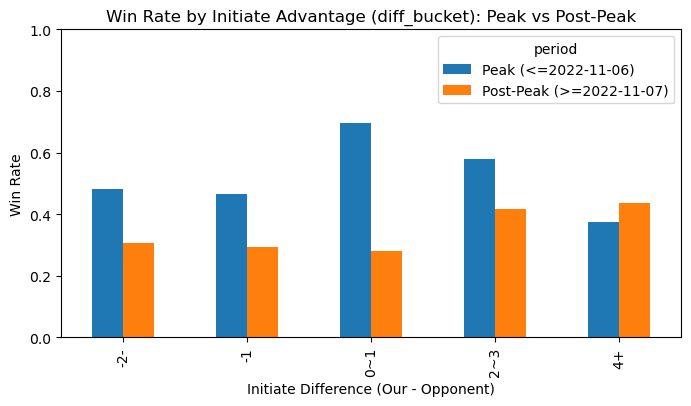

In [23]:
# 시각화
pivot_diff = summary_diff.pivot(index="diff_bucket", columns="period", values="winrate")
pivot_diff.plot(kind="bar", figsize=(8,4))
plt.ylim(0,1)
plt.title("Win Rate by Initiate Advantage (diff_bucket): Peak vs Post-Peak")
plt.ylabel("Win Rate")
plt.xlabel("Initiate Difference (Our - Opponent)")
plt.show()


In [20]:
# 상승기 구간에서는
# 0-1 구간에서 가장 높은 승률을 나타냈다.

# 하락기 구간에서는 전체적으로 낮은 승률이나
# 2-3, 4+ 구간에서 가장 높은 승률을 보여준다.
# 그러나 4+구간의 경기 표본이 적어 신뢰도는 낮아 보인다.

In [30]:
# Final Answer
# initiate 구조는 상승기의 성과를 보조하는 요인으로 작용했을 가능성이 있다.
# 그러나 하락기의 성적 저하의 결정적 요인이 initiate 구조의 변화라고 보기 충분치 않다.
# 상승기 때 성적이 좋았던 2-3, 4-5의 initiate_score 구조를 하락기 때 가장 많이 반영했기 때문이다.
# 이는 initiate가 독립적 결정 요인보다 팁 컨디션, 운영 안정성, 교전 수행력 등
# 해당 분석에서 고려하지 않은 요소들과 결합되어 효과를 발휘하는 맥락적 요소임을 의미한다.